# This notebook goes through building out a data set that is useful for future ML projects around Post Earnings short term trading from 2010 to 2024 by making SQL queries to wrds data base to grab: 
-Analyst estimates and actuals, along with number of estimates (IBES)
-Company Industries (really sector but IBES calls sectors industries)
-Analyst buy hold sell percent recommendations along with number of analysts (IBES) 
- Open and close data and shares outstanding (CRSP)
- SP500 constituents over time (CRSP)


***At the bottom*** I perform a ***Gradient Boosting Classification*** model on stock returns from t = 0 close to t = 1 close, where t = 0 represents the day the markets reacted to the earnings. 
Subjects will be grouped into long, shorts, and flats then the model and their returns will be analyzed.
This data will also be used for future projects, which is why there are some unused features such as different return horizons.

## Below is just pulling in data using SQL queries.

# IMPORTANT NOTE
Feel free to ***skip down to the cell that says END DATA PULLING***. You can just do ctrl f and paste this in: END OF DATA PULLING

### Connecting to the SQL database

In [1]:
import wrds

db = wrds.Connection()

Loading library list...
Done


### Grabbing tickers in SP500 from 2010 to 2024 from CRSP

In [2]:
import pandas as pd 
beg_datestr = '01-01-2010'
end_datestr = '01-15-2025'
begdate = pd.to_datetime(beg_datestr)
enddate = pd.to_datetime(end_datestr)



sp500 = db.raw_sql(f"""
                        select a.*
                        from crsp.msp500list as a;
                        """, date_cols=['start', 'ending'])
sp500 = sp500[sp500['ending']>=begdate]
sp500.reset_index(drop=True, inplace = True)
sp500

,permno,start,ending
0,10078,1992-08-20,2010-01-28
1,10104,1989-08-03,2024-12-31
2,10107,1994-06-07,2024-12-31
3,10137,2000-12-11,2011-02-25
4,10138,1999-10-13,2024-12-31
...,...,...,...
823,93159,2012-07-31,2016-03-29
824,93246,2021-03-22,2024-12-31
825,93422,2010-07-01,2015-06-30
826,93429,2017-03-01,2024-12-31


### permno is a unique identifier that every stock ever has been assigned by CRSP. To get the Earnings estimates and actuals data we need to pull from the IBES database which has thier own unique identifier called a ticker. WRDS provides a program that outputs a csv that maps these two identifiers and scores the confidence of the mapping. 

In [3]:
mapper = pd.read_csv('iclink.csv')
mapper.set_index('permno', inplace = True, drop = True)
mapper = mapper[mapper.index.isin(set(sp500['permno'].to_list()))]
mapper

,ticker,cname,comnam,name_ratio,score
permno,,,,,
14579,003H,PAYCOM SOFTWARE,PAYCOM SOFTWARE INC,100.0,0
14714,004W,ARISTA NETWORKS,ARISTA NETWORKS INC,100.0,0
14939,00C6,KEYSIGHT TECH,KEYSIGHT TECHNOLOGIES INC,76.0,0
15850,00WY,MATCH GRP,MATCH GROUP INC NEW,71.0,0
16342,01AB,ADIENT,ADIENT PLC,100.0,0
...,...,...,...,...,...
89070,ZMH,ZIMMER BIOMET,ZIMMER BIOMET HOLDINGS INC,100.0,0
13788,ZOTS,ZOETIS,ZOETIS INC,100.0,0
40539,ZY,TJX,T J X COMPANIES INC NEW,15.0,1


### Here is Wrds scoreing system for the mapper: 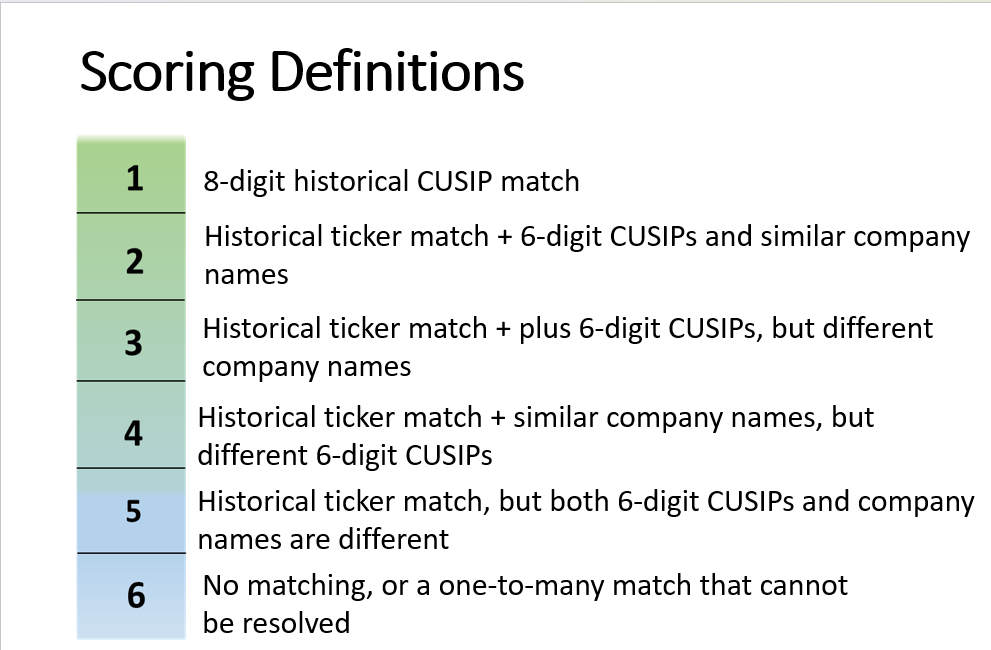. Meaning we are only concerned with 3, 4, 5, or 6 scored matches, so we will take a look at those below

In [4]:
low_confidence_maps = mapper[mapper['score'] >2]
low_confidence_maps

,ticker,cname,comnam,name_ratio,score
permno,,,,,
70519,CICA,CITI CAP,CITIGROUP INC,NaN,6
49015,LINA,LINCOLN NAT CAP,LINCOLN NATIONAL CORP,NaN,5


### In looking at the names it seems fair to leave them in the dataset and assume they are correct. 

### Creating a Map from permno to ticker and adding ticker to the sp500 dataset

In [5]:
ticker_mapper = mapper['ticker'].to_dict()
name_mapper = mapper['cname'].to_dict()
sp500['ticker'] = sp500['permno'].map(ticker_mapper)
sp500['cname'] = sp500['permno'].map(name_mapper)
sp500

,permno,start,ending,ticker,cname
0,10078,1992-08-20,2010-01-28,SUNW,SUN MICROSYSTEMS
1,10104,1989-08-03,2024-12-31,ORCL,ORACLE
2,10107,1994-06-07,2024-12-31,MSFT,MICROSOFT
3,10137,2000-12-11,2011-02-25,AYP,ALLEGHENY ENERGY
4,10138,1999-10-13,2024-12-31,PTRW,T ROWE PRICE GRP
...,...,...,...,...,...
823,93159,2012-07-31,2016-03-29,BLK,VALARIS
824,93246,2021-03-22,2024-12-31,GNRC,GENERAC HLDG
825,93422,2010-07-01,2015-06-30,QEP,QEP RESOURCES
826,93429,2017-03-01,2024-12-31,CBOH,CBOE GLO MARKETS


### Pulling in earnings and sell hold buy data from IBES

In [6]:
## This currently pulls any ticker I need it to pull from my list where anntims_act is in my specified ranges I would also like to grab consensus buy sell holds corresponding to the same thing as well
tickers = sp500['ticker'].unique().tolist()
ticker_list = ",".join([f"'{t}'" for t in tickers]) # sql needs a long string comma seperated

ibes = db.raw_sql(f"""
    SELECT DISTINCT ON (e.ticker, e.fpedats)
    e.ticker,e.cusip, e.oftic, e.meanest, e.actual, e.anndats_act, e.anntims_act, e.numest, e.fpi, e.fpedats, e.statpers, 
    r.numrec, r.buypct, r.sellpct, r.holdpct 
    FROM ibes.statsum_epsus e
    LEFT JOIN ibes.recdsum r 
    ON e.ticker = r.ticker AND e.statpers = r.statpers
    WHERE e.ticker IN ({ticker_list}) AND e.fpi = '6' AND e.anndats_act >= '{beg_datestr}'
    ORDER BY e.ticker, e.fpedats, e.statpers DESC
""", date_cols=['e.anndats_act', 'e.fpe', 'e.statpers'])

In [7]:
ibes 

,ticker,cusip,oftic,meanest,actual,anndats_act,anntims_act,numest,fpi,fpedats,statpers,numrec,buypct,sellpct,holdpct
0,003H,70432V10,PAYC,0.04,0.03,2014-05-16,02:49:00,3.0,6,2014-03-31,2014-05-15,4.0,100.0,0.0,0.0
1,003H,70432V10,PAYC,0.03,0.04,2014-08-05,16:05:00,5.0,6,2014-06-30,2014-07-17,5.0,100.0,0.0,0.0
2,003H,70432V10,PAYC,0.04,0.05,2014-11-04,16:05:00,5.0,6,2014-09-30,2014-10-16,5.0,100.0,0.0,0.0
3,003H,70432V10,PAYC,0.04,0.06,2015-02-10,16:07:00,7.0,6,2014-12-31,2015-01-15,7.0,85.71,0.0,14.29
4,003H,70432V10,PAYC,0.08,0.12,2015-05-06,16:05:00,8.0,6,2015-03-31,2015-04-16,8.0,87.5,0.0,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40188,ZY,87254010,TJX,1.11,1.22,2024-02-28,07:30:00,20.0,6,2024-01-31,2024-02-15,25.0,80.0,0.0,20.0
40189,ZY,87254010,TJX,0.87,0.93,2024-05-22,07:36:00,19.0,6,2024-04-30,2024-05-16,25.0,88.0,0.0,12.0
40190,ZY,87254010,TJX,0.92,0.96,2024-08-21,07:30:00,18.0,6,2024-07-31,2024-08-15,25.0,84.0,4.0,12.0
40191,ZY,87254010,TJX,1.09,1.14,2024-11-20,07:30:00,20.0,6,2024-10-31,2024-11-14,25.0,80.0,4.0,16.0


### Filtering to those that the anndats_act is inside of the band that it was in sp500

In [8]:
ibes['anndats_act'] = pd.to_datetime(ibes['anndats_act'])
sp500['start'] = pd.to_datetime(sp500['start'])
sp500['ending'] = pd.to_datetime(sp500['ending'])

merged = ibes.merge(sp500, on = 'ticker', how = 'left')

# grabbing the ones where anndats_act is in the sp500 time slot bands
filtered = merged[(merged['anndats_act'] >= merged['start']) & 
                  (merged['anndats_act'] <= merged['ending'])]

filtered = filtered.drop(columns = ['oftic', 'fpi', 'fpedats', 'statpers', 'start', 'ending'])
filtered

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname
23,003H,70432V10,0.78,0.86,2020-02-05,16:06:00,16.0,17.0,47.06,0.0,52.94,14579,PAYCOM SOFTWARE
24,003H,70432V10,1.27,1.33,2020-04-28,16:16:00,14.0,14.0,42.86,0.0,57.14,14579,PAYCOM SOFTWARE
25,003H,70432V10,0.63,0.62,2020-08-04,16:05:00,12.0,12.0,41.67,16.67,41.67,14579,PAYCOM SOFTWARE
26,003H,70432V10,0.55,0.7,2020-11-04,16:05:00,13.0,13.0,53.85,15.38,30.77,14579,PAYCOM SOFTWARE
27,003H,70432V10,0.79,0.84,2021-02-10,16:05:00,14.0,14.0,64.29,0.0,35.71,14579,PAYCOM SOFTWARE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41250,ZY,87254010,0.98,1.03,2023-11-15,07:30:00,19.0,24.0,83.33,0.0,16.67,40539,TJX
41251,ZY,87254010,1.11,1.22,2024-02-28,07:30:00,20.0,25.0,80.0,0.0,20.0,40539,TJX
41252,ZY,87254010,0.87,0.93,2024-05-22,07:36:00,19.0,25.0,88.0,0.0,12.0,40539,TJX
41253,ZY,87254010,0.92,0.96,2024-08-21,07:30:00,18.0,25.0,84.0,4.0,12.0,40539,TJX


### Getting valid market dates for sp500 so I can set effective market date based on bmo or amc for announcement time

In [9]:
valid_mkt_dates = db.raw_sql(f"""
SELECT DISTINCT date 
FROM crsp.dsf
WHERE date BETWEEN '{beg_datestr}' AND '{end_datestr}'
ORDER BY date;
""")
valid_mkt_dates

,date
0,2010-01-04
1,2010-01-05
2,2010-01-06
3,2010-01-07
4,2010-01-08
...,...
3769,2024-12-24
3770,2024-12-26
3771,2024-12-27
3772,2024-12-30


In [10]:
# making next mkt date
valid_mkt_dates['date'] = pd.to_datetime(valid_mkt_dates['date'])
valid_mkt_dates['tomorrows_date'] = valid_mkt_dates.shift(-1)
valid_mkt_dates = valid_mkt_dates.dropna()
valid_mkt_dates.set_index('date', inplace = True, drop = True)
valid_mkt_dates

,tomorrows_date
date,
2010-01-04,2010-01-05
2010-01-05,2010-01-06
2010-01-06,2010-01-07
2010-01-07,2010-01-08
2010-01-08,2010-01-11
...,...
2024-12-23,2024-12-24
2024-12-24,2024-12-26
2024-12-26,2024-12-27


In [11]:
tomorrows_date_map = valid_mkt_dates['tomorrows_date'].to_dict()

### Handling cases where the company does not report on a day the market is open. The effective market date for these cases is just the next day the market is open

In [12]:
filtered['is_mkt_date'] = filtered['anndats_act'].isin(tomorrows_date_map.keys())
filtered

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date
23,003H,70432V10,0.78,0.86,2020-02-05,16:06:00,16.0,17.0,47.06,0.0,52.94,14579,PAYCOM SOFTWARE,True
24,003H,70432V10,1.27,1.33,2020-04-28,16:16:00,14.0,14.0,42.86,0.0,57.14,14579,PAYCOM SOFTWARE,True
25,003H,70432V10,0.63,0.62,2020-08-04,16:05:00,12.0,12.0,41.67,16.67,41.67,14579,PAYCOM SOFTWARE,True
26,003H,70432V10,0.55,0.7,2020-11-04,16:05:00,13.0,13.0,53.85,15.38,30.77,14579,PAYCOM SOFTWARE,True
27,003H,70432V10,0.79,0.84,2021-02-10,16:05:00,14.0,14.0,64.29,0.0,35.71,14579,PAYCOM SOFTWARE,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41250,ZY,87254010,0.98,1.03,2023-11-15,07:30:00,19.0,24.0,83.33,0.0,16.67,40539,TJX,True
41251,ZY,87254010,1.11,1.22,2024-02-28,07:30:00,20.0,25.0,80.0,0.0,20.0,40539,TJX,True
41252,ZY,87254010,0.87,0.93,2024-05-22,07:36:00,19.0,25.0,88.0,0.0,12.0,40539,TJX,True
41253,ZY,87254010,0.92,0.96,2024-08-21,07:30:00,18.0,25.0,84.0,4.0,12.0,40539,TJX,True


In [13]:
non_holidays = filtered[filtered['is_mkt_date']].copy()
holidays = filtered[~filtered['is_mkt_date']].copy() # calling it holidays for simplicity but also contains weekends, natural disasters, etc...

open_dates = pd.DatetimeIndex(sorted(tomorrows_date_map.keys()))
def get_next_open_date(row_date): 
    future_days = open_dates[open_dates>row_date] 
    return future_days[0]

holidays.loc[:,'date'] = holidays['anndats_act'].apply(get_next_open_date)
holidays


,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,date
1054,ADM,03948310,0.43,0.45,2012-10-30,12:32:00,2.0,14.0,21.43,14.29,64.29,10516,ARCHER DANIELS,False,2012-10-31
1466,AGN,01849010,1.04,1.06,2012-10-30,09:00:00,25.0,27.0,66.67,0.0,33.33,75646,ALLERGAN INC,False,2012-10-31
2468,AMBP,74340W10,0.12,0.65,2015-04-19,16:01:00,5.0,21.0,71.43,0.0,28.57,85592,PROLOGIS MD,False,2015-04-20
2896,AMR,02376R10,-5.88,-5.54,2020-10-18,02:55:00,17.0,19.0,21.05,52.63,26.32,21020,AMERICAN AIRLINE,False,2020-10-19
3331,APA,03743Q10,1.47,1.29,2022-02-21,17:19:00,22.0,29.0,44.83,3.45,51.72,39490,APA US,False,2022-02-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39610,WMB,96945710,0.49,0.55,2023-02-20,16:15:00,10.0,23.0,60.87,4.35,34.78,38156,WILLIAMS,False,2023-02-21
40036,WUN,95980210,0.45,0.46,2012-10-30,16:00:00,28.0,29.0,51.72,3.45,44.83,91461,WESTERN UNION,False,2012-10-31
40295,X,91290910,0.01,0.14,2012-10-30,08:11:00,18.0,22.0,27.27,13.64,59.09,15069,USX CP,False,2012-10-31
40296,X,91290910,0.01,0.14,2012-10-30,08:11:00,18.0,22.0,27.27,13.64,59.09,76644,U. S. STEEL,False,2012-10-31


### Determining effective date that earnings hits mkt and making that the index. Note that I am going to use a simple cutoff of before 1600 to catch odd edge cases when reported during market hours, but this is extremely rare

In [14]:
import numpy as np 
from datetime import time

df = non_holidays
df['next_mkt_date'] = df['anndats_act'].map(tomorrows_date_map)
df['anntims_act'] = pd.to_datetime(df['anntims_act'], format='%H:%M:%S').dt.time
mkt_close = time(16, 0, 0)

df['date'] = np.where(df['anntims_act'] < mkt_close, df['anndats_act'], df['next_mkt_date']) # pretty cool function I havent used in a while structure is df['col'] = np.where(df['col'] conditional, value if true, value if false)
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,next_mkt_date,date
23,003H,70432V10,0.78,0.86,2020-02-05,16:06:00,16.0,17.0,47.06,0.0,52.94,14579,PAYCOM SOFTWARE,True,2020-02-06,2020-02-06
24,003H,70432V10,1.27,1.33,2020-04-28,16:16:00,14.0,14.0,42.86,0.0,57.14,14579,PAYCOM SOFTWARE,True,2020-04-29,2020-04-29
25,003H,70432V10,0.63,0.62,2020-08-04,16:05:00,12.0,12.0,41.67,16.67,41.67,14579,PAYCOM SOFTWARE,True,2020-08-05,2020-08-05
26,003H,70432V10,0.55,0.7,2020-11-04,16:05:00,13.0,13.0,53.85,15.38,30.77,14579,PAYCOM SOFTWARE,True,2020-11-05,2020-11-05
27,003H,70432V10,0.79,0.84,2021-02-10,16:05:00,14.0,14.0,64.29,0.0,35.71,14579,PAYCOM SOFTWARE,True,2021-02-11,2021-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41250,ZY,87254010,0.98,1.03,2023-11-15,07:30:00,19.0,24.0,83.33,0.0,16.67,40539,TJX,True,2023-11-16,2023-11-15
41251,ZY,87254010,1.11,1.22,2024-02-28,07:30:00,20.0,25.0,80.0,0.0,20.0,40539,TJX,True,2024-02-29,2024-02-28
41252,ZY,87254010,0.87,0.93,2024-05-22,07:36:00,19.0,25.0,88.0,0.0,12.0,40539,TJX,True,2024-05-23,2024-05-22
41253,ZY,87254010,0.92,0.96,2024-08-21,07:30:00,18.0,25.0,84.0,4.0,12.0,40539,TJX,True,2024-08-22,2024-08-21


In [15]:
df = df.set_index('date')
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,next_mkt_date
date,,,,,,,,,,,,,,,
2020-02-06,003H,70432V10,0.78,0.86,2020-02-05,16:06:00,16.0,17.0,47.06,0.0,52.94,14579,PAYCOM SOFTWARE,True,2020-02-06
2020-04-29,003H,70432V10,1.27,1.33,2020-04-28,16:16:00,14.0,14.0,42.86,0.0,57.14,14579,PAYCOM SOFTWARE,True,2020-04-29
2020-08-05,003H,70432V10,0.63,0.62,2020-08-04,16:05:00,12.0,12.0,41.67,16.67,41.67,14579,PAYCOM SOFTWARE,True,2020-08-05
2020-11-05,003H,70432V10,0.55,0.7,2020-11-04,16:05:00,13.0,13.0,53.85,15.38,30.77,14579,PAYCOM SOFTWARE,True,2020-11-05
2021-02-11,003H,70432V10,0.79,0.84,2021-02-10,16:05:00,14.0,14.0,64.29,0.0,35.71,14579,PAYCOM SOFTWARE,True,2021-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15,ZY,87254010,0.98,1.03,2023-11-15,07:30:00,19.0,24.0,83.33,0.0,16.67,40539,TJX,True,2023-11-16
2024-02-28,ZY,87254010,1.11,1.22,2024-02-28,07:30:00,20.0,25.0,80.0,0.0,20.0,40539,TJX,True,2024-02-29
2024-05-22,ZY,87254010,0.87,0.93,2024-05-22,07:36:00,19.0,25.0,88.0,0.0,12.0,40539,TJX,True,2024-05-23


### The market closes at 1 on 7/3, 12/24, and Black Friday, so making sure no issues with those dates

In [16]:
third_of_july = df[(df['anndats_act'].dt.month == 7)& (df['anndats_act'].dt.day == 3)] # both bmo so good
third_of_july

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,next_mkt_date
date,,,,,,,,,,,,,,,
2024-07-03,CDG2,21036P10,3.46,3.57,2024-07-03,07:30:00,14.0,25.0,88.0,0.0,12.0,69796,CONSTELLATION,True,2024-07-05
2019-07-03,LUK,47233W10,0.24,0.41,2019-07-03,07:00:00,1.0,1.0,100.0,0.0,0.0,20415,JEFFERIES FINCL,True,2019-07-05


### both are announcing BMO, so assignment of effective mkt date is good 

In [17]:
xmas_eve =  df[(df['anndats_act'].dt.month == 12)& (df['anndats_act'].dt.day == 24)]
xmas_eve 

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,next_mkt_date
date,,,,,,,,,,,,,,,


### Nobody announced on Christmas Eve, all set

In [18]:
black_fridays = black_fridays = [
    pd.Timestamp('2010-11-26'),
    pd.Timestamp('2011-11-25'),
    pd.Timestamp('2012-11-23'),
    pd.Timestamp('2013-11-29'),
    pd.Timestamp('2014-11-28'),
    pd.Timestamp('2015-11-27'),
    pd.Timestamp('2016-11-25'),
    pd.Timestamp('2017-11-24'),
    pd.Timestamp('2018-11-23'),
    pd.Timestamp('2019-11-29'),
    pd.Timestamp('2020-11-27'),
    pd.Timestamp('2021-11-26'),
    pd.Timestamp('2022-11-25'),
    pd.Timestamp('2023-11-24'),
    pd.Timestamp('2024-11-29'),
]

black_friday = df[df['anndats_act'].isin(black_fridays)]
black_friday

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,next_mkt_date
date,,,,,,,,,,,,,,,


### Nobody announced on Black Friday, all set

### Appending the holidays df to the regular df and removing non common columns

In [19]:

df = df.drop(columns = ['next_mkt_date'])
holidays.set_index('date', inplace = True, drop = True)
df = pd.concat([df, holidays], axis=0, ignore_index = False)
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date
date,,,,,,,,,,,,,,
2020-02-06,003H,70432V10,0.78,0.86,2020-02-05,16:06:00,16.0,17.0,47.06,0.0,52.94,14579,PAYCOM SOFTWARE,True
2020-04-29,003H,70432V10,1.27,1.33,2020-04-28,16:16:00,14.0,14.0,42.86,0.0,57.14,14579,PAYCOM SOFTWARE,True
2020-08-05,003H,70432V10,0.63,0.62,2020-08-04,16:05:00,12.0,12.0,41.67,16.67,41.67,14579,PAYCOM SOFTWARE,True
2020-11-05,003H,70432V10,0.55,0.7,2020-11-04,16:05:00,13.0,13.0,53.85,15.38,30.77,14579,PAYCOM SOFTWARE,True
2021-02-11,003H,70432V10,0.79,0.84,2021-02-10,16:05:00,14.0,14.0,64.29,0.0,35.71,14579,PAYCOM SOFTWARE,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,WMB,96945710,0.49,0.55,2023-02-20,16:15:00,10.0,23.0,60.87,4.35,34.78,38156,WILLIAMS,False
2012-10-31,WUN,95980210,0.45,0.46,2012-10-30,16:00:00,28.0,29.0,51.72,3.45,44.83,91461,WESTERN UNION,False
2012-10-31,X,91290910,0.01,0.14,2012-10-30,08:11:00,18.0,22.0,27.27,13.64,59.09,15069,USX CP,False


In [20]:
df = df.sort_index()
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date
date,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,50.0,88668,MONSANTO,True
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,54.55,53866,FAMILY DOLLAR ST,True
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,46.67,52708,LENNAR,True
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,44.44,69796,CONSTELLATION,True
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,60.87,77659,BED BATH,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,10.26,53613,MICRON TECH,True
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,33.33,89508,CARMAX,True
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,46.34,57665,NIKE,True


In [21]:
valid_mkt_dates = valid_mkt_dates.reset_index()
valid_mkt_dates['yesterdays_date'] = valid_mkt_dates['date'].shift(1)
valid_mkt_dates = valid_mkt_dates.dropna()
valid_mkt_dates

,date,tomorrows_date,yesterdays_date
1,2010-01-05,2010-01-06,2010-01-04
2,2010-01-06,2010-01-07,2010-01-05
3,2010-01-07,2010-01-08,2010-01-06
4,2010-01-08,2010-01-11,2010-01-07
5,2010-01-11,2010-01-12,2010-01-08
...,...,...,...
3768,2024-12-23,2024-12-24,2024-12-20
3769,2024-12-24,2024-12-26,2024-12-23
3770,2024-12-26,2024-12-27,2024-12-24
3771,2024-12-27,2024-12-30,2024-12-26


In [22]:
valid_mkt_dates['t = 1'] = valid_mkt_dates['date'].shift(-1)
valid_mkt_dates['t = 2'] = valid_mkt_dates['date'].shift(-2)
valid_mkt_dates['t = 3'] = valid_mkt_dates['date'].shift(-3)


valid_mkt_dates = valid_mkt_dates.dropna()
valid_mkt_dates.set_index('date', inplace = True, drop = True)
valid_mkt_dates

,tomorrows_date,yesterdays_date,t = 1,t = 2,t = 3
date,,,,,
2010-01-05,2010-01-06,2010-01-04,2010-01-06,2010-01-07,2010-01-08
2010-01-06,2010-01-07,2010-01-05,2010-01-07,2010-01-08,2010-01-11
2010-01-07,2010-01-08,2010-01-06,2010-01-08,2010-01-11,2010-01-12
2010-01-08,2010-01-11,2010-01-07,2010-01-11,2010-01-12,2010-01-13
2010-01-11,2010-01-12,2010-01-08,2010-01-12,2010-01-13,2010-01-14
...,...,...,...,...,...
2024-12-18,2024-12-19,2024-12-17,2024-12-19,2024-12-20,2024-12-23
2024-12-19,2024-12-20,2024-12-18,2024-12-20,2024-12-23,2024-12-24
2024-12-20,2024-12-23,2024-12-19,2024-12-23,2024-12-24,2024-12-26


In [23]:
prev_day_map = valid_mkt_dates['yesterdays_date'].to_dict()
t_1_map = valid_mkt_dates['t = 1'].to_dict()
t_2_map = valid_mkt_dates['t = 2'].to_dict()
t_3_map = valid_mkt_dates['t = 3'].to_dict()

df['t = -1'] = df.index.map(prev_day_map)
df['t = 1'] = df.index.map(t_1_map)
df['t = 2'] = df.index.map(t_2_map)
df['t = 3'] = df.index.map(t_3_map)

df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,holdpct,permno,cname,is_mkt_date,t = -1,t = 1,t = 2,t = 3
date,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,50.0,88668,MONSANTO,True,2010-01-05,2010-01-07,2010-01-08,2010-01-11
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,54.55,53866,FAMILY DOLLAR ST,True,2010-01-05,2010-01-07,2010-01-08,2010-01-11
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,46.67,52708,LENNAR,True,2010-01-06,2010-01-08,2010-01-11,2010-01-12
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,44.44,69796,CONSTELLATION,True,2010-01-06,2010-01-08,2010-01-11,2010-01-12
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,60.87,77659,BED BATH,True,2010-01-06,2010-01-08,2010-01-11,2010-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,10.26,53613,MICRON TECH,True,2024-12-18,2024-12-20,2024-12-23,2024-12-24
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,33.33,89508,CARMAX,True,2024-12-18,2024-12-20,2024-12-23,2024-12-24
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,46.34,57665,NIKE,True,2024-12-19,2024-12-23,2024-12-24,2024-12-26


### Grabbing daily open, close, and shares outstanding in thousands for all tickers and adding respective dates and closes to df

In [24]:
permnos = tuple(df['permno'].unique().tolist())


price_and_cap_df = db.raw_sql(f"""
SELECT permno, date, prc, openprc, shrout
FROM crsp.dsf
WHERE permno IN {permnos}
  AND date BETWEEN '{beg_datestr}' AND '{end_datestr}'
  AND prc IS NOT NULL
ORDER BY permno, date
"""
, date_cols=['date'])

price_and_cap_df

,permno,date,prc,openprc,shrout
0,10104,2010-01-04,24.85,24.66,5011220.0
1,10104,2010-01-05,24.82,24.72,5011220.0
2,10104,2010-01-06,24.46,24.77,5011220.0
3,10104,2010-01-07,24.38,24.46,5011220.0
4,10104,2010-01-08,24.68,24.28,5011220.0
...,...,...,...,...,...
432889,93436,2024-12-24,462.28,435.89999,3210060.0
432890,93436,2024-12-26,454.13,465.16,3210060.0
432891,93436,2024-12-27,431.66,449.51999,3210060.0
432892,93436,2024-12-30,417.41,419.39999,3210060.0


### Adding market cap and splitting based on buckets 1 is mega, 2 is large, 3 is medium. This is just a rough system based on current market distribution of cap types, because raw cutoffs are not accurate due to inflation, growth, and market conditions

In [25]:
price_and_cap_df['mkt_cap'] = price_and_cap_df['prc']*price_and_cap_df['shrout']*1000
price_and_cap_df= price_and_cap_df.sort_values(by=['date', 'mkt_cap'], ascending=[True, False])
price_and_cap_df['rank_by_date'] = price_and_cap_df.groupby('date').cumcount() + 1

# This is just a rough bucket system for mkt cap based on current spread of mega caps, large caps and mid caps in sp500
def assign_bucket(rank):
    if rank <= 50:
        return 1
    elif rank <= 200:
        return 2
    else:
        return 3

price_and_cap_df['bucket'] = price_and_cap_df['rank_by_date'].apply(assign_bucket)
price_and_cap_df

,permno,date,prc,openprc,shrout,mkt_cap,rank_by_date,bucket
70369,11850,2010-01-04,69.15,68.72,4731898.0,327210746700.000061,1,1
3774,10107,2010-01-04,30.95,30.62,8811000.0,272700450000.0,2,1
35603,55976,2010-01-04,54.23,53.74,3810172.0,206625627560.0,3,1
272382,14593,2010-01-04,214.00999,213.42999,906282.0,193953401757.179962,4,1
400306,18163,2010-01-04,61.12,61.11,2921734.0,178576382079.999969,5,1
...,...,...,...,...,...,...,...,...
310856,15272,2024-12-31,13.6,13.76,57950.0,788120000.0,581,3
345161,75573,2024-12-31,22.74,21.85,30118.0,684883320.0,582,3
215890,29102,2024-12-31,57.17,54.59,8991.0,514015470.0,583,3
156389,80539,2024-12-31,0.93,0.92,184458.0,171545940.0,584,3


### Adding in pricing and mkt cap data from price and cap df

In [26]:
df = df.reset_index()

price_df_t_minus_1 = price_and_cap_df.rename(columns={'date': 't = -1', 'prc': 't = -1 close'})
price_df_t_0 = price_and_cap_df.rename(columns={'prc': 't = 0 close'})
price_df_t_1 = price_and_cap_df.rename(columns={'date': 't = 1', 'prc': 't = 1 close', 'openprc':'t = 1 open'})
price_df_t_2 = price_and_cap_df.rename(columns={'date': 't = 2', 'prc': 't = 2 close', 'openprc':'t = 2 open'})
price_df_t_3 = price_and_cap_df.rename(columns={'date': 't = 3', 'prc': 't = 3 close', 'openprc':'t = 3 open'})

df = df.merge(
    price_df_t_minus_1[['permno', 't = -1', 't = -1 close']], 
    on=['permno', 't = -1'],
    how='left'
)

df = df.merge(
    price_df_t_0[['permno', 'date', 't = 0 close', 'bucket']],
    on=['permno', 'date'],
    how='left'
)


df = df.merge(
    price_df_t_1[['permno', 't = 1', 't = 1 close', 't = 1 open']],
    on=['permno', 't = 1'],
    how='left'
)

df = df.merge(
    price_df_t_2[['permno', 't = 2', 't = 2 close', 't = 2 open']],
    on=['permno', 't = 2'],
    how='left'
)

df = df.merge(
    price_df_t_3[['permno', 't = 3', 't = 3 close', 't = 3 open']],
    on=['permno', 't = 3'],
    how='left'
)

df.set_index('date', inplace = True)
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3,t = -1 close,t = 0 close,bucket,t = 1 close,t = 1 open,t = 2 close,t = 2 open,t = 3 close,t = 3 open
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,...,2010-01-11,85.27,86.27,1.0,85.96,85.7,86.65,85.58,85.01,86.67
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,...,2010-01-11,27.49,30.92,3.0,30.53,30.84,30.14,30.37,30.55,30.2
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,...,2010-01-12,13.7,15.46,3.0,15.95,15.4,16.26,16.07,16.13,16.15
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,...,2010-01-12,16.13,15.97,3.0,15.66,15.88,15.69,15.66,15.65,15.63
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,...,2010-01-12,39.23,41.94,3.0,42.03,41.06,41.78,42.0,41.39,41.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,...,2024-12-24,103.9,87.09,2.0,90.12,85.406,89.72,90.0,89.28,89.58
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,...,2024-12-24,81.42,84.23,3.0,84.27,85.4,83.7,84.11,84.91,84.0
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,...,2024-12-26,77.1,76.94,2.0,76.76,76.325,76.79,76.75,76.94,76.6


### Adding returns from (-1, 0), (0, 1 open), (0, 1 close), (0, 2 open), (0, 2 close), (0, 3 open), (0, 3 close)

In [27]:
# These are all standard returns not log
df['earnings_reaction_return'] = (df['t = 0 close']/df['t = -1 close'] -1)*100
df['(0, 1 open)_return'] = (df['t = 0 close']/df['t = 1 open'] -1)*100
df['(0, 1 close)_return'] = (df['t = 0 close']/df['t = 1 close'] -1)*100
df['(0, 2 open)_return'] = (df['t = 0 close']/df['t = 2 open'] -1)*100
df['(0, 2 close)_return'] = (df['t = 0 close']/df['t = 2 close'] -1)*100
df['(0, 3 open)_return'] = (df['t = 0 close']/df['t = 3 open'] -1)*100
df['(0, 3 close)_return'] = (df['t = 0 close']/df['t = 3 close'] -1)*100

df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 2 open,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return"
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,...,85.58,85.01,86.67,1.172745,0.665111,0.360633,0.806263,-0.438546,-0.461521,1.482179
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,...,30.37,30.55,30.2,12.477264,0.259403,1.277432,1.810998,2.587923,2.384106,1.211129
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,...,16.07,16.13,16.15,12.846715,0.38961,-3.0721,-3.795893,-4.920049,-4.272446,-4.153751
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,...,15.66,15.65,15.63,-0.99194,0.566751,1.979566,1.979566,1.784576,2.175304,2.044728
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,...,42.0,41.39,41.32,6.907979,2.143205,-0.214133,-0.142857,0.382958,1.500484,1.328823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,...,90.0,89.28,89.58,-16.179018,1.971758,-3.362184,-3.233333,-2.931342,-2.779638,-2.452957
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,...,84.11,84.91,84.0,3.45124,-1.370023,-0.047466,0.14267,0.633214,0.27381,-0.800848
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,...,76.75,76.94,76.6,-0.207523,0.805765,0.234497,0.247557,0.195338,0.443864,0.0


### Adding sector, which is called industry in ibes, I refer to it as industry above as well to remain constent with terminology 

In [28]:
tickers = tuple(df['ticker'].unique().tolist())

ibes_sector = db.raw_sql(f"""
SELECT n.ticker AS ticker, n.indnam, n.mod_date, n.Cname
FROM tr_ibes_guidance.id_guidance n
JOIN (
    SELECT ticker, MAX(mod_date) as max_mod_date
    FROM tr_ibes_guidance.id_guidance
    WHERE ticker IN {tickers}
    GROUP BY ticker
) t
ON n.ticker = t.ticker AND n.mod_date = t.max_mod_date;
""")
ibes_sector = ibes_sector.drop(columns = ['mod_date'])
ibes_sector

,ticker,indnam,cname
0,003H,TECHNOLOGY,PAYCOM SOFTWARE INC
1,004W,TECHNOLOGY,ARISTA NETWORKS INC
2,00C6,TECHNOLOGY,KEYSIGHT TECHNOLOGIES INC
3,00WY,TECHNOLOGY,MATCH GROUP INC
4,032M,TECHNOLOGY,VONTIER CORP
...,...,...,...
762,ZBRA,TECHNOLOGY,ZEBRA TECHNOLOGIES CORP
763,ZION,FINANCE,ZIONS BANCORPORATION NA
764,ZMH,HEALTH CARE,ZIMMER BIOMET HOLDINGS INC
765,ZOTS,HEALTH CARE,ZOETIS INC


In [29]:
len(tickers)

773

### mismatch in length so we are missing some

In [30]:
original_tickers = set(df['ticker'].unique())
filtered_tickers = set(ibes_sector['ticker'].unique())

missing = original_tickers - filtered_tickers
missing

{'02J8',
 '053G',
 'BKHT/1',
 'CEG',
 'CMCS/2',
 'CPGX',
 'CSRAW',
 'DCHA/2',
 'ERIE',
 'FRCA',
 'GEHC',
 'GEV',
 'GOOG/1',
 'KVUE',
 'NFXAV',
 'OGN',
 'SOLV',
 'UARM/1',
 'VLTOW'}

In [31]:
missing_map = (df[df['ticker'].isin(missing)].drop_duplicates(subset=['ticker', 'cname']).set_index('ticker')['cname'].to_dict())
missing_map

{'BKHT/1': 'BERKSHIRE',
 'DCHA/2': 'DISCOVERY INC',
 'GOOG/1': 'ALPHABET',
 'CPGX': 'COLUMBIA US',
 'CMCS/2': 'COMCAST',
 'CSRAW': 'CSRA',
 'UARM/1': 'UNDER ARMOUR',
 'FRCA': 'FRST REP BK',
 'NFXAV': 'FOX',
 '02J8': 'AMCR',
 'OGN': 'ORGANON',
 'CEG': 'CONSTELLATION PA',
 'GEHC': 'GE HEALTHCARE',
 'VLTOW': 'VERALTO',
 'KVUE': 'KENVUE',
 'GEV': 'GE VERNOVA',
 'SOLV': 'SOLVENTUM',
 '053G': 'SMURFIT WESTROCK',
 'ERIE': 'ERIE INDEMNITY'}

### It looks like the bulk of the issue is coming from companies with spinoffs or multiple classes of shares. 
### I do not want class a and class b shares overweighting single occurrences, so they will be removed from the dataset, but the spinoffs will stay

In [32]:
to_remove = {'BKHT/1', 'DCHA/2', 'GOOG/1', 'CMCS/2', 'UARM/1', 'NFXAV'}
missing_df = pd.DataFrame(list(missing_map.items()), columns = ['ticker', 'cname'])
missing_df = missing_df[~missing_df['ticker'].isin(to_remove)]
df = df[~df['ticker'].isin(to_remove)]
missing_df

,ticker,cname
3,CPGX,COLUMBIA US
5,CSRAW,CSRA
7,FRCA,FRST REP BK
9,02J8,AMCR
10,OGN,ORGANON
11,CEG,CONSTELLATION PA
12,GEHC,GE HEALTHCARE
13,VLTOW,VERALTO
14,KVUE,KENVUE
15,GEV,GE VERNOVA


### Adding in the respective indnam of each ticker that should remain

In [33]:
ibes_sector['indnam'].unique()

<StringArray>
[           'TECHNOLOGY',         'CAPITAL GOODS',     'CONSUMER SERVICES',
           'HEALTH CARE', 'CONSUMER NON-DURABLES',               'FINANCE',
                'ENERGY',      'PUBLIC UTILITIES',      'BASIC INDUSTRIES',
        'TRANSPORTATION',     'CONSUMER DURABLES']
Length: 11, dtype: string

In [34]:
missing_df['indnam'] = [
    "FINANCE",               # CPGX
    "TECHNOLOGY",            # CSRAW
    "FINANCE",               # FRCA
    "BASIC INDUSTRIES",      # 02J8 (Amcor)
    "HEALTH CARE",           # OGN
    "PUBLIC UTILITIES",      # CEG
    "HEALTH CARE",           # GEHC
    "CAPITAL GOODS",         # VLTOW
    "CONSUMER NON-DURABLES", # KVUE
    "CAPITAL GOODS",         # GEV
    "HEALTH CARE",           # SOLV
    "BASIC INDUSTRIES",      # 053G
    "FINANCE"                # ERIE
]
missing_df

,ticker,cname,indnam
3,CPGX,COLUMBIA US,FINANCE
5,CSRAW,CSRA,TECHNOLOGY
7,FRCA,FRST REP BK,FINANCE
9,02J8,AMCR,BASIC INDUSTRIES
10,OGN,ORGANON,HEALTH CARE
11,CEG,CONSTELLATION PA,PUBLIC UTILITIES
12,GEHC,GE HEALTHCARE,HEALTH CARE
13,VLTOW,VERALTO,CAPITAL GOODS
14,KVUE,KENVUE,CONSUMER NON-DURABLES
15,GEV,GE VERNOVA,CAPITAL GOODS


In [35]:
ibes_sector = pd.concat([ibes_sector, missing_df], axis = 0, ignore_index = True)
ibes_sector

,ticker,indnam,cname
0,003H,TECHNOLOGY,PAYCOM SOFTWARE INC
1,004W,TECHNOLOGY,ARISTA NETWORKS INC
2,00C6,TECHNOLOGY,KEYSIGHT TECHNOLOGIES INC
3,00WY,TECHNOLOGY,MATCH GROUP INC
4,032M,TECHNOLOGY,VONTIER CORP
...,...,...,...
775,KVUE,CONSUMER NON-DURABLES,KENVUE
776,GEV,CAPITAL GOODS,GE VERNOVA
777,SOLV,HEALTH CARE,SOLVENTUM
778,053G,BASIC INDUSTRIES,SMURFIT WESTROCK


In [36]:
len(df['ticker'].unique().tolist())

767

In [37]:
len(ibes_sector['ticker'].unique().tolist())

767

In [38]:
duplicates = ibes_sector[ibes_sector['ticker'].duplicated(keep=False)]
duplicates


,ticker,indnam,cname
126,CDAY,TECHNOLOGY,CERIDIAN HCM HOLDING INC
127,CDAY,TECHNOLOGY,DAYFORCE INC
173,CSC,TECHNOLOGY,DXC TECHNOLOGY COMAPNY
174,CSC,TECHNOLOGY,DXC TECHNOLOGY CO
247,ERI,CONSUMER SERVICES,ELDORADO RESORTS INC
248,ERI,CONSUMER SERVICES,CAESARS ENTERTAINMENT INC
264,FBHS,CAPITAL GOODS,FORTUNE BRANDS HOME & SECURITY I
265,FBHS,CAPITAL GOODS,FORTUNE BRANDS INNOVATIONS INC
300,GDI,CAPITAL GOODS,INGERSOLL RAND INC
301,GDI,CAPITAL GOODS,INGERSOLL RAND INC


### Nothing in there that needs to be kept so picking 1


In [39]:
ibes_sector = ibes_sector.drop(columns = ['cname'])
ibes_sector

,ticker,indnam
0,003H,TECHNOLOGY
1,004W,TECHNOLOGY
2,00C6,TECHNOLOGY
3,00WY,TECHNOLOGY
4,032M,TECHNOLOGY
...,...,...
775,KVUE,CONSUMER NON-DURABLES
776,GEV,CAPITAL GOODS
777,SOLV,HEALTH CARE
778,053G,BASIC INDUSTRIES


In [40]:
ibes_sector = ibes_sector.drop_duplicates(subset='ticker').reset_index(drop=True)
ibes_sector

,ticker,indnam
0,003H,TECHNOLOGY
1,004W,TECHNOLOGY
2,00C6,TECHNOLOGY
3,00WY,TECHNOLOGY
4,032M,TECHNOLOGY
...,...,...
762,KVUE,CONSUMER NON-DURABLES
763,GEV,CAPITAL GOODS
764,SOLV,HEALTH CARE
765,053G,BASIC INDUSTRIES


In [41]:
ibes_sector = ibes_sector.set_index('ticker')
sector_map = ibes_sector['indnam'].to_dict()
df = df.copy()
df.loc[:,'Industry'] = df['ticker'].map(sector_map)
df


,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return",Industry
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,...,85.01,86.67,1.172745,0.665111,0.360633,0.806263,-0.438546,-0.461521,1.482179,BASIC INDUSTRIES
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,...,30.55,30.2,12.477264,0.259403,1.277432,1.810998,2.587923,2.384106,1.211129,CONSUMER SERVICES
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,...,16.13,16.15,12.846715,0.38961,-3.0721,-3.795893,-4.920049,-4.272446,-4.153751,CONSUMER DURABLES
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,...,15.65,15.63,-0.99194,0.566751,1.979566,1.979566,1.784576,2.175304,2.044728,CONSUMER NON-DURABLES
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,...,41.39,41.32,6.907979,2.143205,-0.214133,-0.142857,0.382958,1.500484,1.328823,FINANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,...,89.28,89.58,-16.179018,1.971758,-3.362184,-3.233333,-2.931342,-2.779638,-2.452957,TECHNOLOGY
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,...,84.91,84.0,3.45124,-1.370023,-0.047466,0.14267,0.633214,0.27381,-0.800848,CONSUMER SERVICES
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,...,76.94,76.6,-0.207523,0.805765,0.234497,0.247557,0.195338,0.443864,0.0,CONSUMER NON-DURABLES


# END OF DATA PULLING

### Checking to see how much of the universe is lost by limiting universe to 3 or more analyst estimates and recommendations

In [42]:
df[(df['numest']<3) | (df['numrec'] <3)]

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return",Industry
date,,,,,,,,,,,,,,,,,,,,,
2010-01-27,BXP,10112110,0.35,0.38,2010-01-26,18:40:00,2.0,18.0,50.0,5.56,...,66.87,65.71,0.540791,-1.034221,-0.489371,-1.124449,0.308309,-0.973977,-2.69179,FINANCE
2010-01-29,CPWR,20563810,0.1,0.11,2010-01-28,16:13:00,2.0,2.0,100.0,0.0,...,7.42,7.48,-2.567394,0.264201,-0.262812,0.264201,1.470588,1.470588,2.291105,TECHNOLOGY
2010-02-04,KIM,49446R10,0.05,0.11,2010-02-03,17:03:00,2.0,21.0,28.57,19.05,...,12.8,12.75,0.0,0.0,-2.390131,-2.239382,0.47619,-0.705882,-1.09375,FINANCE
2010-02-18,UEP,02360810,0.05,0.37,2010-02-18,08:05:00,1.0,5.0,0.0,40.0,...,25.29,25.42,0.944882,0.078064,-0.038986,-0.620155,0.905155,0.86546,1.383946,PUBLIC UTILITIES
2010-02-23,VNO,92904210,0.23,-0.84,2010-02-23,09:03:00,1.0,9.0,22.22,11.11,...,65.72,65.65,-1.690012,-0.798894,-1.133058,-0.04644,-1.704978,-1.645088,-1.749848,FINANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-08,VSTE,92840M10,0.98,0.9,2024-08-08,07:00:00,2.0,12.0,91.67,0.0,...,80.45,79.03,6.93712,1.384615,0.559512,0.113938,1.436634,0.063267,-1.702921,PUBLIC UTILITIES
2024-08-08,NRGE,62937750,1.59,3.37,2024-08-08,06:56:00,2.0,10.0,50.0,0.0,...,81.86,80.61,8.186485,0.360407,-2.889525,-2.986189,-2.378866,-3.275028,-4.752016,PUBLIC UTILITIES
2024-10-25,VRSN,92343E10,2.01,2.07,2024-10-24,16:08:00,2.0,4.0,50.0,0.0,...,177.39,178.60001,-2.085139,-0.761018,1.222974,1.625919,1.392846,1.48935,2.181628,TECHNOLOGY


### Restricting universe to cases where there is three or more estimates and 3 or more recommendations. Doing this gives more credit to the estimates and recommendations since there are more opinions involved

In [43]:
df = df[(df['numest']>=3) & (df['numrec'] >=3)]
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return",Industry
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,...,85.01,86.67,1.172745,0.665111,0.360633,0.806263,-0.438546,-0.461521,1.482179,BASIC INDUSTRIES
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,...,30.55,30.2,12.477264,0.259403,1.277432,1.810998,2.587923,2.384106,1.211129,CONSUMER SERVICES
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,...,16.13,16.15,12.846715,0.38961,-3.0721,-3.795893,-4.920049,-4.272446,-4.153751,CONSUMER DURABLES
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,...,15.65,15.63,-0.99194,0.566751,1.979566,1.979566,1.784576,2.175304,2.044728,CONSUMER NON-DURABLES
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,...,41.39,41.32,6.907979,2.143205,-0.214133,-0.142857,0.382958,1.500484,1.328823,FINANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,...,89.28,89.58,-16.179018,1.971758,-3.362184,-3.233333,-2.931342,-2.779638,-2.452957,TECHNOLOGY
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,...,84.91,84.0,3.45124,-1.370023,-0.047466,0.14267,0.633214,0.27381,-0.800848,CONSUMER SERVICES
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,...,76.94,76.6,-0.207523,0.805765,0.234497,0.247557,0.195338,0.443864,0.0,CONSUMER NON-DURABLES


## Analyzing missing values and replacing or removing where appropriate

In [44]:
df.isna().sum()

ticker                      0
cusip                       0
meanest                     0
actual                      3
anndats_act                 0
anntims_act                 0
numest                      0
numrec                      0
buypct                      0
sellpct                     0
holdpct                     0
permno                      0
cname                       0
is_mkt_date                 0
t = -1                      0
t = 1                       0
t = 2                       0
t = 3                       0
t = -1 close                0
t = 0 close                 1
bucket                      1
t = 1 close                 1
t = 1 open                  1
t = 2 close                 4
t = 2 open                  4
t = 3 close                 5
t = 3 open                  5
earnings_reaction_return    1
(0, 1 open)_return          1
(0, 1 close)_return         1
(0, 2 open)_return          4
(0, 2 close)_return         4
(0, 3 open)_return          5
(0, 3 clos

### Looking at missing actuals

In [45]:
df[df['actual'].isna()].drop(columns = ['anntims_act', 'Industry'])

,ticker,cusip,meanest,actual,anndats_act,numest,numrec,buypct,sellpct,holdpct,...,t = 2 open,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-23,ABBV,00287Y10,0.99,<NA>,2013-01-23,7.0,10.0,50.0,0.0,50.0,...,37.52,36.89,37.65,3.789127,0.026462,0.907635,0.746269,0.531915,0.398406,2.466793
2020-05-07,WATS,G0177J10,3.94,<NA>,2020-05-07,6.0,17.0,11.76,0.0,88.24,...,<NA>,<NA>,<NA>,-0.464176,-0.010352,-0.015537,<NA>,<NA>,<NA>,<NA>
2024-05-03,PDP,72378710,4.87,<NA>,2024-05-02,18.0,25.0,16.0,4.0,80.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>



### ALLERGAN was bought by Abbvie on May 8 2020 DROP
### Pioneer merged with Exon on the day they were supposed to announce earnings DROP
### ABBV is just missing the data. Here is a screenshot from another provider: 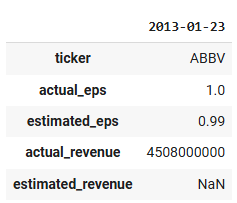

### Inputing actual for ABBV and removing WATS and PDP by just calling to remove those missing actuals


In [46]:
df.loc[(df.index == '2013-01-23') & (df['ticker'] == 'ABBV'), 'actual'] = 1.0
df.loc[(df.index == '2013-01-23') & (df['ticker'] == 'ABBV')]

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return",Industry
date,,,,,,,,,,,,,,,,,,,,,
2013-01-23,ABBV,00287Y10,0.99,1.0,2013-01-23,07:47:00,7.0,10.0,50.0,0.0,...,36.89,37.65,3.789127,0.026462,0.907635,0.746269,0.531915,0.398406,2.466793,HEALTH CARE


In [47]:
df[df['actual'].isna()].drop(columns = ['anntims_act', 'Industry'])

,ticker,cusip,meanest,actual,anndats_act,numest,numrec,buypct,sellpct,holdpct,...,t = 2 open,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return"
date,,,,,,,,,,,,,,,,,,,,,
2020-05-07,WATS,G0177J10,3.94,<NA>,2020-05-07,6.0,17.0,11.76,0.0,88.24,...,<NA>,<NA>,<NA>,-0.464176,-0.010352,-0.015537,<NA>,<NA>,<NA>,<NA>
2024-05-03,PDP,72378710,4.87,<NA>,2024-05-02,18.0,25.0,16.0,4.0,80.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [48]:
df = df[~df['actual'].isna()]
df.isna().sum()

ticker                      0
cusip                       0
meanest                     0
actual                      0
anndats_act                 0
anntims_act                 0
numest                      0
numrec                      0
buypct                      0
sellpct                     0
holdpct                     0
permno                      0
cname                       0
is_mkt_date                 0
t = -1                      0
t = 1                       0
t = 2                       0
t = 3                       0
t = -1 close                0
t = 0 close                 0
bucket                      0
t = 1 close                 0
t = 1 open                  0
t = 2 close                 2
t = 2 open                  2
t = 3 close                 3
t = 3 open                  3
earnings_reaction_return    0
(0, 1 open)_return          0
(0, 1 close)_return         0
(0, 2 open)_return          2
(0, 2 close)_return         2
(0, 3 open)_return          3
(0, 3 clos

### Looking at t = 3 close to see issues since 3 has the most and most likely overlap for first 2 

In [49]:
df[df['t = 3 close'].isna()]['cname']

date
2011-02-24    ALLEGHENY ENERGY
2015-01-22            COVIDIEN
2015-07-02    FAMILY DOLLAR ST
Name: cname, dtype: object

### Alegheny merged with FirstEnergy corp on feb 25 2011, so it will be dropped. People already knew about this event ahead of time, so no reason to trade it
### Medtronic bought Covidien on jan 26 so not considered, news of this was known ahead of time
### Dollar Tree bought out Family dollar on july 6, again not considered and this was already known ahead of time

### Given that all three missing pricing data is the result of mergers and buyouts, none of them will be considered, as this was known ahead of time


In [50]:
df = df[~df['t = 3 close'].isna()]
df.isna().sum()

ticker                      0
cusip                       0
meanest                     0
actual                      0
anndats_act                 0
anntims_act                 0
numest                      0
numrec                      0
buypct                      0
sellpct                     0
holdpct                     0
permno                      0
cname                       0
is_mkt_date                 0
t = -1                      0
t = 1                       0
t = 2                       0
t = 3                       0
t = -1 close                0
t = 0 close                 0
bucket                      0
t = 1 close                 0
t = 1 open                  0
t = 2 close                 0
t = 2 open                  0
t = 3 close                 0
t = 3 open                  0
earnings_reaction_return    0
(0, 1 open)_return          0
(0, 1 close)_return         0
(0, 2 open)_return          0
(0, 2 close)_return         0
(0, 3 open)_return          0
(0, 3 clos

In [51]:
df

,ticker,cusip,meanest,actual,anndats_act,anntims_act,numest,numrec,buypct,sellpct,...,t = 3 close,t = 3 open,earnings_reaction_return,"(0, 1 open)_return","(0, 1 close)_return","(0, 2 open)_return","(0, 2 close)_return","(0, 3 open)_return","(0, 3 close)_return",Industry
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,0.0,-0.02,2010-01-06,08:00:00,17.0,18.0,38.89,11.11,...,85.01,86.67,1.172745,0.665111,0.360633,0.806263,-0.438546,-0.461521,1.482179,BASIC INDUSTRIES
2010-01-06,FDO,30700010,0.47,0.49,2010-01-06,07:00:00,20.0,22.0,40.91,4.55,...,30.55,30.2,12.477264,0.259403,1.277432,1.810998,2.587923,2.384106,1.211129,CONSUMER SERVICES
2010-01-07,LEN,52605710,-0.47,0.19,2010-01-07,06:00:00,16.0,15.0,46.67,6.67,...,16.13,16.15,12.846715,0.38961,-3.0721,-3.795893,-4.920049,-4.272446,-4.153751,CONSUMER DURABLES
2010-01-07,CDG2,21036P10,0.52,0.54,2010-01-07,07:30:00,8.0,9.0,22.22,33.33,...,15.65,15.63,-0.99194,0.566751,1.979566,1.979566,1.784576,2.175304,2.044728,CONSUMER NON-DURABLES
2010-01-07,BBBY,07589610,0.42,0.58,2010-01-06,16:15:00,23.0,23.0,34.78,4.35,...,41.39,41.32,6.907979,2.143205,-0.214133,-0.142857,0.382958,1.500484,1.328823,FINANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,1.76,1.79,2024-12-18,16:01:00,24.0,39.0,87.18,2.56,...,89.28,89.58,-16.179018,1.971758,-3.362184,-3.233333,-2.931342,-2.779638,-2.452957,TECHNOLOGY
2024-12-19,KMX,14313010,0.59,0.81,2024-12-19,06:50:00,12.0,18.0,50.0,16.67,...,84.91,84.0,3.45124,-1.370023,-0.047466,0.14267,0.633214,0.27381,-0.800848,CONSUMER SERVICES
2024-12-20,NIKE,65410610,0.65,0.78,2024-12-19,16:15:00,25.0,41.0,48.78,4.88,...,76.94,76.6,-0.207523,0.805765,0.234497,0.247557,0.195338,0.443864,0.0,CONSUMER NON-DURABLES


In [52]:
df = df.drop(columns = ['(0, 1 open)_return',
 '(0, 2 close)_return',
 '(0, 2 open)_return',
 '(0, 3 close)_return',
 '(0, 3 open)_return',
 'anndats_act',
 'anntims_act',
 'cname',
 'is_mkt_date',
 't = -1',
 't = -1 close',
 't = 0 close',
 't = 1',
 't = 1 close',
 't = 1 open',
 't = 2',
 't = 2 close',
 't = 2 open',
 't = 3',
 't = 3 close',
 't = 3 open'])

# Performing data preproccessing 

In [54]:
df['beat_earnings'] = ((df['actual'] - df['meanest']) > 0).astype(int)
df = df.drop(columns = ['actual', 'meanest', 'holdpct']) # holdpct is redundent since 100 - (buy + sell) = hold always
df

,ticker,cusip,numest,numrec,buypct,sellpct,permno,mkt_cap_bin,earnings_reaction_return,"(0, 1 close)_return",Industry,beat_earnings
date,,,,,,,,,,,,
2010-01-06,MONN,61166W10,17.0,18.0,38.89,11.11,88668,1.0,1.172745,0.360633,BASIC INDUSTRIES,0
2010-01-06,FDO,30700010,20.0,22.0,40.91,4.55,53866,3.0,12.477264,1.277432,CONSUMER SERVICES,1
2010-01-07,LEN,52605710,16.0,15.0,46.67,6.67,52708,3.0,12.846715,-3.0721,CONSUMER DURABLES,1
2010-01-07,CDG2,21036P10,8.0,9.0,22.22,33.33,69796,3.0,-0.99194,1.979566,CONSUMER NON-DURABLES,1
2010-01-07,BBBY,07589610,23.0,23.0,34.78,4.35,77659,3.0,6.907979,-0.214133,FINANCE,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,24.0,39.0,87.18,2.56,53613,2.0,-16.179018,-3.362184,TECHNOLOGY,1
2024-12-19,KMX,14313010,12.0,18.0,50.0,16.67,89508,3.0,3.45124,-0.047466,CONSUMER SERVICES,1
2024-12-20,NIKE,65410610,25.0,41.0,48.78,4.88,57665,2.0,-0.207523,0.234497,CONSUMER NON-DURABLES,1


In [55]:
df = pd.get_dummies(df, columns=['Industry', 'mkt_cap_bin'], dtype = int)
df

,ticker,cusip,numest,numrec,buypct,sellpct,permno,earnings_reaction_return,"(0, 1 close)_return",beat_earnings,...,Industry_CONSUMER SERVICES,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,MONN,61166W10,17.0,18.0,38.89,11.11,88668,1.172745,0.360633,0,...,0,0,0,0,0,0,0,1,0,0
2010-01-06,FDO,30700010,20.0,22.0,40.91,4.55,53866,12.477264,1.277432,1,...,1,0,0,0,0,0,0,0,0,1
2010-01-07,LEN,52605710,16.0,15.0,46.67,6.67,52708,12.846715,-3.0721,1,...,0,0,0,0,0,0,0,0,0,1
2010-01-07,CDG2,21036P10,8.0,9.0,22.22,33.33,69796,-0.99194,1.979566,1,...,0,0,0,0,0,0,0,0,0,1
2010-01-07,BBBY,07589610,23.0,23.0,34.78,4.35,77659,6.907979,-0.214133,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,24.0,39.0,87.18,2.56,53613,-16.179018,-3.362184,1,...,0,0,0,0,0,1,0,0,1,0
2024-12-19,KMX,14313010,12.0,18.0,50.0,16.67,89508,3.45124,-0.047466,1,...,1,0,0,0,0,0,0,0,0,1
2024-12-20,NIKE,65410610,25.0,41.0,48.78,4.88,57665,-0.207523,0.234497,1,...,0,0,0,0,0,0,0,0,1,0


In [56]:
df_numerical = df.drop(columns = ['ticker', 'cusip', 'permno'])
df_numerical

,numest,numrec,buypct,sellpct,earnings_reaction_return,"(0, 1 close)_return",beat_earnings,Industry_BASIC INDUSTRIES,Industry_CAPITAL GOODS,Industry_CONSUMER DURABLES,...,Industry_CONSUMER SERVICES,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,17.0,18.0,38.89,11.11,1.172745,0.360633,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-01-06,20.0,22.0,40.91,4.55,12.477264,1.277432,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2010-01-07,16.0,15.0,46.67,6.67,12.846715,-3.0721,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2010-01-07,8.0,9.0,22.22,33.33,-0.99194,1.979566,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2010-01-07,23.0,23.0,34.78,4.35,6.907979,-0.214133,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,24.0,39.0,87.18,2.56,-16.179018,-3.362184,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2024-12-19,12.0,18.0,50.0,16.67,3.45124,-0.047466,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2024-12-20,25.0,41.0,48.78,4.88,-0.207523,0.234497,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Creating three buckets for returns of entire df based on returns of the  33rd, and 66th percentiles from the training data

[-0.69538085  0.63824767]


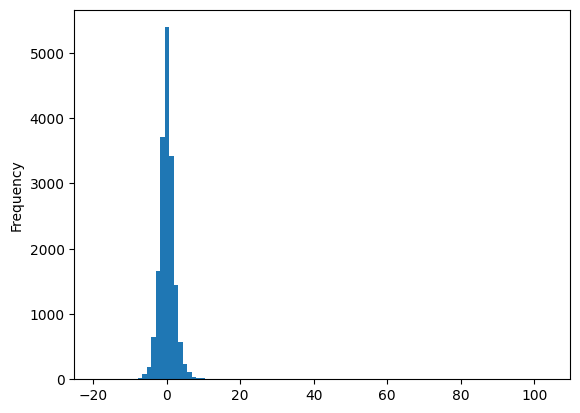

In [57]:
training = df[df.index < '2019-01-01']
training['(0, 1 close)_return'].plot(kind = 'hist', bins = 100)

percentiles = np.percentile(training['(0, 1 close)_return'], [33,66])
print(percentiles)

### Setting up bins for entire data set based on training set, so if return > .63 then long, the middle is flat, and return < -.69 short

In [58]:
# Assign target classes for entire dataset
def classify_return(x, percentiles):
    if x < percentiles[0]:
        return 0  # short
    elif x > percentiles[1]:
        return 2  # long
    else:
        return 1  # middle / flat

df_numerical['target_class'] = df_numerical['(0, 1 close)_return'].apply(lambda x: classify_return(x, percentiles))
df_numerical = df_numerical.drop(columns = ['(0, 1 close)_return'])
df_numerical

,numest,numrec,buypct,sellpct,earnings_reaction_return,beat_earnings,Industry_BASIC INDUSTRIES,Industry_CAPITAL GOODS,Industry_CONSUMER DURABLES,Industry_CONSUMER NON-DURABLES,...,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0,target_class
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,17.0,18.0,38.89,11.11,1.172745,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2010-01-06,20.0,22.0,40.91,4.55,12.477264,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
2010-01-07,16.0,15.0,46.67,6.67,12.846715,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-01-07,8.0,9.0,22.22,33.33,-0.99194,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2
2010-01-07,23.0,23.0,34.78,4.35,6.907979,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,24.0,39.0,87.18,2.56,-16.179018,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2024-12-19,12.0,18.0,50.0,16.67,3.45124,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2024-12-20,25.0,41.0,48.78,4.88,-0.207523,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


### Brief Summary of features and predictor variable

FEATURES
* numest: Number of analysts estimating earnings
* numrec: Number of analysts giving a recommendation for the stock strong buy, buy, hold, sell, strong sell
* earnings_reaction_return: The close to close return of the stock on the day the market reacted to earnings
* Industries are self explanatory
* mkt_cap_bin_1.0: Is 1 if the stock was in the top 50 stocks in sp500 weighted by mkt cap that day 
* mkt_cap_bin_2.0: is the next 50 to 200 stocks 
* mkt_cap_bin_3.0 is the remaining stocks 
* beat earnings: 1 if mean earnings estimate >= actual earnings estimate and 0 otherwise
* buypct: The percent of analysts that rated the stock a buy or strong buy 
* sellpct: Same thing for sell or strong sell

TARGET: 
* 0 means the return from the close when the market reacted to earnings to the next days close is < .69%, which was the 33rd percentile of returns from the training set. I call this shorts
* 2 means the return from the close when the market reacted to earnings to the next days close is > .63%, which was the 66th percentile of returns from the training set. I call this longs
* 1 means return is between shorts and longs. I call this flats



# GradientBoostingClassifier modeling


In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix



train = df_numerical[df_numerical.index <'2019-01-01']
test = df_numerical[df_numerical.index >='2019-01-01']

X_train = train.drop(columns = ['target_class'])
y_train = train['target_class']

X_test = test.drop(columns = ['target_class'])
y_test = test['target_class']


gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)


print(classification_report(y_test, y_pred))
conf_m = confusion_matrix(y_test, y_pred)
confusion_mat = pd.DataFrame(conf_m, index = ['actual short', 'actual flat', 'actual long'], columns = ['predicted short', 'predicted flat', 'predicted long'])
confusion_mat

              precision    recall  f1-score   support

           0       0.39      0.25      0.31      4322
           1       0.31      0.42      0.35      3150
           2       0.37      0.41      0.39      4253

    accuracy                           0.35     11725
   macro avg       0.36      0.36      0.35     11725
weighted avg       0.36      0.35      0.35     11725



,predicted short,predicted flat,predicted long
actual short,1075,1467,1780
actual flat,649,1323,1178
actual long,1001,1522,1730


### The models overall accuracy is .35, which is slightly above just guessing uniformly. We can see from the confusion matrix that there are lots of long to short and short to long prediction errors. This is not good because it means that we are not seperating the two classes properly, and that if one was to employ this strategy they would be taking the wrong position far to frequently. 

### A future solution for the application of a trading strategy could be to force the model during training to put observations that it is unsure of into the flat class, and overpenalize the case when the model predicts long and the actual is short or predicts short and the actual is long. This could be done through a custom loss function in XGBoost. This way while our overall accuracy may decrease due to 'punting' unsure ones into the flat class, the accuracy of predicting longs and shorts increases and our strategy can become more reliable.  


## Here is the feature importances that our tree classifier has decided on. 

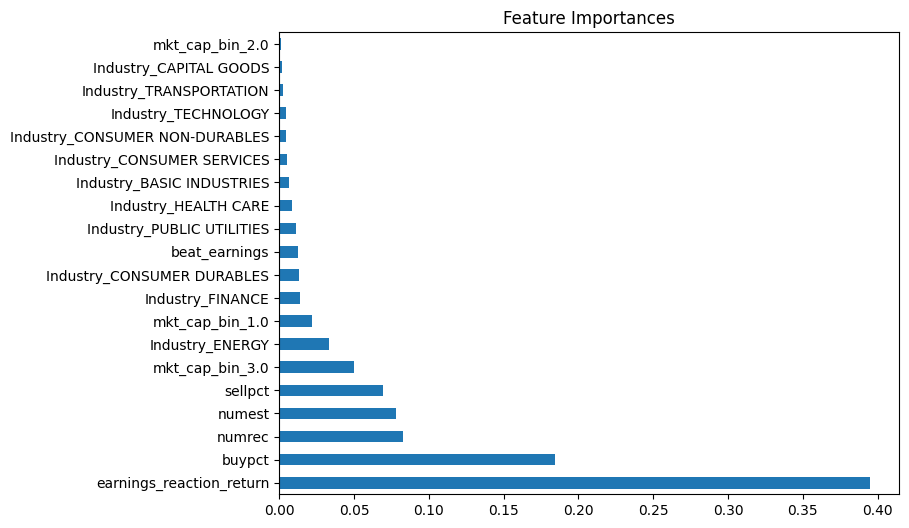

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances
importances = pd.Series(gbc.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8,6))
plt.title("Feature Importances")
plt.show()


### We can see that the model weights earnings reaction return the highest, followed by analyst level items, then being a small cap, energy,then everything else becomes less and less relevant

### Something of interest may be the fact that numest is of more importance than whether or not the company beat earnings. This makes intuitive sense because the more guesses they are the more likely the average of the guesses is correct, so the more estimators the better. This could also be attributed to numrec and numest being fairly close at most times. 

## The distribution of returns of the in sample strategy

/tmp/33173679.1.jupyterhub.q/ipykernel_2154085/2685676333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_long_form['model_prediction'] = y_output


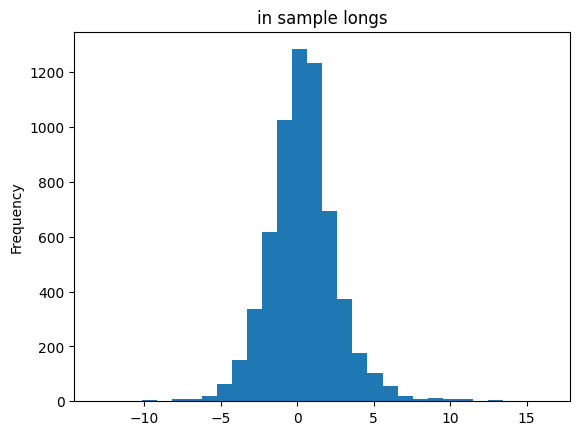

count       6213.0
mean      0.370054
std       2.260899
min     -13.103448
25%       -0.95457
50%       0.328176
75%       1.555847
max      16.397229
Name: (0, 1 close)_return, dtype: Float64

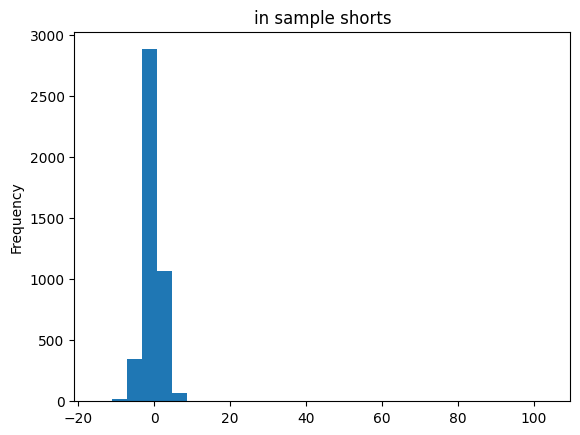

None

count        4391.0
mean      -0.362808
std        2.743014
min      -15.072579
25%       -1.658398
50%       -0.408163
75%        0.832688
max      103.719547
Name: (0, 1 close)_return, dtype: Float64

In [61]:
y_output = gbc.predict(X_train)
in_sample_long_form = df[df.index <'2019-01-01']
in_sample_long_form['model_prediction'] = y_output

in_longs = in_sample_long_form[in_sample_long_form['model_prediction'] == 2]
in_shorts = in_sample_long_form[in_sample_long_form['model_prediction'] == 0]

in_longs['(0, 1 close)_return'].plot(kind = 'hist', bins = 30, title = "in sample longs")
plt.show()
display(in_longs['(0, 1 close)_return'].describe())
in_shorts['(0, 1 close)_return'].plot(kind = 'hist', bins = 30, title = "in sample shorts")
display(plt.show())
in_shorts['(0, 1 close)_return'].describe()

### In training we can see that there is some directional bias in the means for both toward our position, but this is very low, especially relative to the deviation of returns. Not to mention it is most likely completely overfiting. 
Also, note the outlair at 100, this is in sample training too. In a future project when I have some more knowledge about how the loss function works, I would like to build one that overpenalizes being wrong between longs and shorts and whenever the model is unsure it punts the classification into the flat slot


In [62]:
out_of_sample_long_form = df[df.index >='2019-01-01']
out_of_sample_long_form['model_prediction'] = y_pred
out_of_sample_long_form

/tmp/33173679.1.jupyterhub.q/ipykernel_2154085/793002830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_of_sample_long_form['model_prediction'] = y_pred


,ticker,cusip,numest,numrec,buypct,sellpct,permno,earnings_reaction_return,"(0, 1 close)_return",beat_earnings,...,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0,model_prediction
date,,,,,,,,,,,,,,,,,,,,,
2019-01-04,LW,51327210,6.0,6.0,33.33,0.0,16431,3.56262,7.129695,1,...,0,0,0,0,0,0,0,0,1,0
2019-01-09,CDG2,21036P10,20.0,24.0,66.67,8.33,69796,-12.417315,-5.621203,1,...,0,0,0,0,0,0,0,1,0,2
2019-01-09,LEN,52605710,14.0,19.0,84.21,0.0,52708,7.927256,2.479522,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-15,UNIH,91324P10,22.0,24.0,95.83,0.0,92655,3.55156,-1.755523,1,...,0,0,1,0,0,0,1,0,0,2
2019-01-15,CHL,46625H10,23.0,30.0,53.33,3.33,47896,0.733109,-0.8,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,DRAM,59511210,24.0,39.0,87.18,2.56,53613,-16.179018,-3.362184,1,...,0,0,0,0,1,0,0,1,0,2
2024-12-19,KMX,14313010,12.0,18.0,50.0,16.67,89508,3.45124,-0.047466,1,...,0,0,0,0,0,0,0,0,1,2
2024-12-20,NIKE,65410610,25.0,41.0,48.78,4.88,57665,-0.207523,0.234497,1,...,0,0,0,0,0,0,0,1,0,1


In [63]:
longs = out_of_sample_long_form[out_of_sample_long_form['model_prediction'] == 2]
longs

,ticker,cusip,numest,numrec,buypct,sellpct,permno,earnings_reaction_return,"(0, 1 close)_return",beat_earnings,...,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0,model_prediction
date,,,,,,,,,,,,,,,,,,,,,
2019-01-09,CDG2,21036P10,20.0,24.0,66.67,8.33,69796,-12.417315,-5.621203,1,...,0,0,0,0,0,0,0,1,0,2
2019-01-15,UNIH,91324P10,22.0,24.0,95.83,0.0,92655,3.55156,-1.755523,1,...,0,0,1,0,0,0,1,0,0,2
2019-01-15,DAL,24736170,19.0,20.0,95.0,0.0,91926,0.167539,0.694737,1,...,0,0,0,0,0,1,0,1,0,2
2019-01-16,BLKI,09247X10,13.0,15.0,86.67,0.0,87267,3.077043,0.126059,0,...,0,1,0,0,0,0,0,1,0,2
2019-01-17,PPG,69350610,22.0,24.0,41.67,0.0,22509,4.700605,1.830599,1,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-19,CTAS,17290810,15.0,19.0,42.11,10.53,23660,-10.568037,-2.219969,1,...,0,0,0,0,0,0,0,1,0,2
2024-12-19,LW,51327210,8.0,12.0,50.0,0.0,16431,-20.097162,0.660332,0,...,0,0,0,0,0,0,0,0,1,2
2024-12-19,LEN,52605710,15.0,21.0,42.86,4.76,52708,-5.160009,0.231742,0,...,0,0,0,0,0,0,0,0,1,2


In [64]:
shorts =  out_of_sample_long_form[out_of_sample_long_form['model_prediction'] == 0]
shorts

,ticker,cusip,numest,numrec,buypct,sellpct,permno,earnings_reaction_return,"(0, 1 close)_return",beat_earnings,...,Industry_ENERGY,Industry_FINANCE,Industry_HEALTH CARE,Industry_PUBLIC UTILITIES,Industry_TECHNOLOGY,Industry_TRANSPORTATION,mkt_cap_bin_1.0,mkt_cap_bin_2.0,mkt_cap_bin_3.0,model_prediction
date,,,,,,,,,,,,,,,,,,,,,
2019-01-04,LW,51327210,6.0,6.0,33.33,0.0,16431,3.56262,7.129695,1,...,0,0,0,0,0,0,0,0,1,0
2019-01-09,LEN,52605710,14.0,19.0,84.21,0.0,52708,7.927256,2.479522,0,...,0,0,0,0,0,0,0,0,1,0
2019-01-15,CHL,46625H10,23.0,30.0,53.33,3.33,47896,0.733109,-0.8,0,...,0,1,0,0,0,0,1,0,0,0
2019-01-15,MRKT,G4756710,17.0,18.0,66.67,5.56,14704,2.255791,-0.665232,1,...,0,0,0,0,0,0,0,0,1,0
2019-01-15,FRCA,33616C10,23.0,23.0,34.78,0.0,12448,11.844913,-1.328452,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-13,AOVG,11135F10,28.0,40.0,90.0,0.0,93002,24.432636,-10.08,1,...,0,0,0,0,1,0,1,0,0,0
2024-12-19,DRI,23719410,26.0,31.0,64.52,3.23,81655,14.743229,-2.212271,0,...,0,0,0,0,0,0,0,0,1,0
2024-12-19,FD1,30307510,17.0,21.0,14.29,28.57,83597,3.526059,1.284336,1,...,0,0,0,0,0,0,0,0,1,0


# Here is the distribution of returns for out of sample

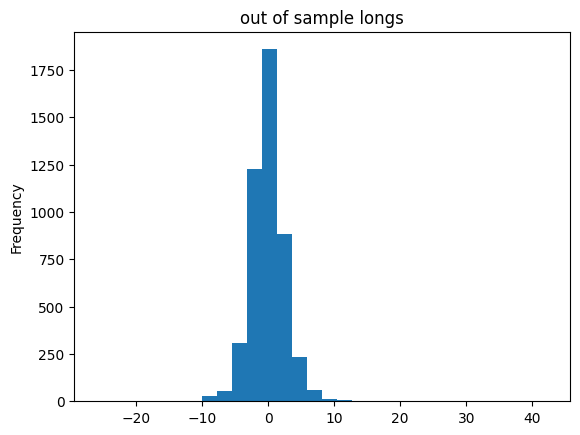

count       4688.0
mean      0.002077
std       2.793229
min     -25.913838
25%      -1.475565
50%      -0.078558
75%        1.45605
max      42.355009
Name: (0, 1 close)_return, dtype: Float64

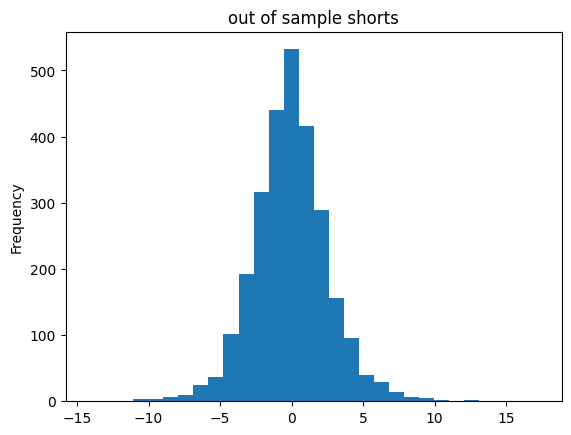

None

count       2725.0
mean      -0.09035
std       2.644642
min     -14.214835
25%      -1.656663
50%      -0.123656
75%       1.431889
max      17.295389
Name: (0, 1 close)_return, dtype: Float64

In [65]:
longs['(0, 1 close)_return'].plot(kind = 'hist', bins = 30, title = "out of sample longs")
plt.show()
display(longs['(0, 1 close)_return'].describe())
shorts['(0, 1 close)_return'].plot(kind = 'hist', bins = 30, title = "out of sample shorts")
display(plt.show())
shorts['(0, 1 close)_return'].describe()

### The average return is in the direction of our position on both sets, but it is pretty much just zero for both, which is why this is not worth backtesting, particularly due to the small return relative to volatility, the sharpe ratio on this strategy would be horrible. 

# To summarize: 
This classification model is not a usable for a long short strategy, and a future addition to this project would be to implement it with XGBoost and build out a custom loss function to overpenalize putting longs in shorts and shorts in longs. 